In [ ]:
import numpy as np

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP
import sys

In [4]:
# install metapy if running in Google Colab
if 'google.colab' in sys.modules:
    !pip install meta-py

In [16]:
import metapy.tsp.tsp_io as io
import metapy.tsp.euclidean as e
from metapy.tsp.objective import OptimisedSimpleTSPObjective

In [7]:
def gen_matrix(cities, as_integer=False):
    """
    Creates a numpy array of euclidian distances between 2 sets of
    cities
    
    Parameters:
    ----------
    points: numpy.array
        coordinate pairs
    
    as_integers: bool, optional (default=False)
        If true then round to nearest int
        Behaviour: 1.5 -> 2
                   1.2 -> 1
                   1.8 -> 2
                   
    Returns:
    -------
        np.ndarray
            Matrix of city to city costs
    
    """
    size = len(cities)
    matrix = np.zeros(shape=(size, size))
    
    row = 0
    col = 0
    
    for city1 in cities:
        col = 0
        for city2 in cities:
            distance = e.euclidean_distance(city1, city2)
            if as_integer:
                distance = int(Decimal(distance).quantize(0, ROUND_HALF_UP))
            matrix[row, col] = distance
            col+=1
        row +=1
        
    return matrix

In [8]:
def plot_tour(tour, cities, figsize=(6,4)):
    '''
    Plots a tour.  Each city visited is
    labelled in order.  Red point is the initial city.
    
    Params:
    ------
    tour: np.ndarray
        ordered vector representing tour e.g. [1, 4, 2, 3]
        
    cities: np.ndarray
        matrix representing city coordinates
        
    figsize: tuple, optional (default = (6,3))
        tuple of ints for figure size
        
    Returns
    -------
        tuple of matplotlib figure, and axis
    '''

    tour_length = len(tour)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    #plot points
    ax.plot(cities[:tour_length][:, 0],
            cities[:tour_length][:, 1],'bo')

    #plot lines
    for j in range(len(tour)-1):
        city_1 = tour[j]
        city_2 = tour[j+1]

        #lookup coordinates
        coords_1 = cities[city_1]
        coords_2 = cities[city_2]
        coords = np.vstack([coords_1, coords_2])

        #plot lines
        ax.plot(coords[:,0], coords[:,1], 'g-')
        
        #show order in tour
        ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(j))

    #add in loop back colour code in red...
    city_1 = tour[-1]
    city_2 = tour[0]

    coords_1 = cities[city_1]
    coords_2 = cities[city_2]
    coords = np.vstack([coords_1, coords_2])
    ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(tour_length-1))
    ax.plot(coords[:,0], coords[:,1], 'r--')
        
    return fig, ax

Read in instance of the TSP and generate cost matrix

We will use the famous st70 dataset consisting of 70 cities.

> Note the original data was sourced from (and all credit goes to) the fantastic [TSPLib](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html)


In [23]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main' \
           + '/data/st70.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)

#should be an numpy.ndarray
print(type(cities))

# should be 70 cities
print(cities.shape)

#print first 2 coordinate pairs
print(cities[:2])

<class 'numpy.ndarray'>
(70, 2)
[[64. 96.]
 [80. 39.]]


In [44]:
# generate matrix 
TRUNC = 70
trunc_cities = cities[:TRUNC]
matrix = gen_matrix(trunc_cities, as_integer=True)

matrix

array([[ 0., 59., 73., ..., 79., 21., 20.],
       [59.,  0., 19., ..., 38., 47., 55.],
       [73., 19.,  0., ..., 21., 65., 73.],
       ...,
       [79., 38., 21., ...,  0., 76., 83.],
       [21., 47., 65., ..., 76.,  0.,  8.],
       [20., 55., 73., ..., 83.,  8.,  0.]])

## Representing a tour

In [45]:
#create ordered list of cities to visit
tour = np.arange(TRUNC)
tour

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

## Visualising a tour

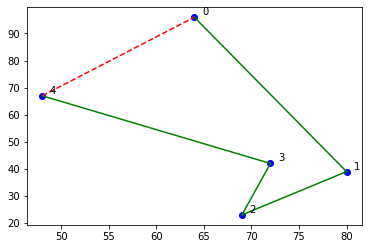

In [15]:
plot_tour(tour, trunc_cities);

In [357]:
class NearestNeighbourNP(object):
    
    def __init__(self, cities, cost_matrix, obj):
        # cities
        self.cities = cities
        
        # 2D cost matrix
        self.matrix = cost_matrix
        
        # objective function
        self.obj = obj
        
        # constructed solution
        self.solution = None
        
        # properties access externally
        self.best_cost = -np.inf
        self.best_solution = None
        
    def solve(self):
        """
        Constructs a tour based on nearest neighbour method.
        Assume that first city in tour is base city.
        """
        
        # constructed solution
        self.solution = np.ones(len(self.cities), np.uint8) * -1
        
        from_city = self.cities[0]
        self.solution[0] = from_city
                
        for i in range(1, len(self.cities)):
            to_city = self.closest_city_not_in_tour(from_city)
            self.solution[i] = self.cities[to_city]
            from_city = to_city
        
        self.best_cost = self.obj.evaluate(self.solution)
        self.best_solution = self.solution
                
    def closest_city_not_in_tour(self, from_city):
        
        # remaining cities to visit
        remaining = self.cities[~np.isin(self.cities, self.solution)]
        
        # return the index 
        # this is a 2nd loop that ideally would be eliminated, but it is 
        # relatively inexpensive.
        return remaining[self.matrix[from_city, remaining].argmin()]

In [358]:
solution = np.ones(5, dtype=np.int8) * -1
solution[0] = 0
solution[1] = 2
solution

array([ 0,  2, -1, -1, -1], dtype=int8)

In [359]:
cities_to_visit = np.arange(5)
cities_to_visit

array([0, 1, 2, 3, 4])

In [360]:
np.isin(cities_to_visit, solution) 

array([ True, False,  True, False, False])

In [361]:
~np.isin(cities_to_visit, solution) 

array([False,  True, False,  True,  True])

In [362]:
from_city = 0
remaining = cities_to_visit[~np.isin(cities_to_visit, solution)]
remaining

array([1, 3, 4])

In [363]:
trunc_matrix = matrix[1:6, 1:6]
trunc_matrix

array([[ 0., 19.,  9., 43., 22.],
       [19.,  0., 19., 49., 23.],
       [ 9., 19.,  0., 35., 14.],
       [43., 49., 35.,  0., 26.],
       [22., 23., 14., 26.,  0.]])

In [364]:
trunc_matrix[from_city]

array([ 0., 19.,  9., 43., 22.])

In [365]:
trunc_matrix[from_city, remaining]

array([19., 43., 22.])

In [366]:
closest_index = trunc_matrix[from_city, remaining].argmin()
closest_index

0

%timeit nn_np.solve()

In [369]:
nn_np.best_cost

830.0

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8d616ee3c8>)

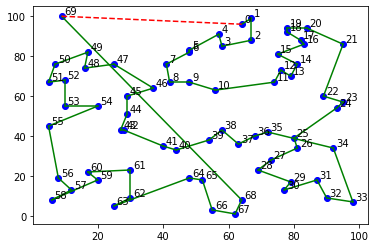

In [370]:
plot_tour(nn_np.best_solution, trunc_cities)

In [380]:
def tour_cost(tour, matrix):
    """
    The total distance in the tour.
    
    Params:
    -------
    tour: array-like
        list of cities to visit in order.
    matrix: array-like
        numpy array of costs.
    """
    cost = 0
    
    for i in range(len(tour) - 1):
        cost += matrix[tour[i]][tour[i+1]]
    cost += matrix[tour[len(tour)-1]][tour[0]]
    return cost

In [399]:
class NearestNeighbourSP(object):
    
    def __init__(self, cities, cost_matrix):
        self.cities = cities
        self.matrix = cost_matrix
        
        # current solution
        self.solution = None
        
        # external properties
        self.best_cost = float('inf')
        self.best_solution = None
    
    def solve(self):
        """
        Constructs a tour based on nearest neighbour method.
        Assume that first city in tour is base city.
        """
        
        from_city = self.cities[0]
        self.solution = [from_city]
                
        for _ in range(len(self.cities) - 1):
            to_city = self.closest_city_not_in_tour(from_city)
            self.solution.append(self.cities[to_city])
            from_city = to_city
        
        self.best_cost = tour_cost(self.solution, self.matrix)
        self.best_solution = self.solution
                   
    def closest_city_not_in_tour(self, from_city):
        min_cost = 999
        min_index = from_city
        
        for to_city in range(len(self.cities) - 1):
            
            if (min_cost > self.matrix[from_city][to_city]):
                              
                if (self.cities[to_city] not in self.solution):
                    min_index = to_city
                    min_cost = self.matrix[from_city][to_city]
        
        return min_index

In [400]:
nn_sp = NearestNeighbourSP(tour.tolist(), matrix)

In [401]:
nn_sp.solve()

In [412]:
%timeit nn_sp.solve()

1.16 ms ± 9.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [403]:
nn_sp.best_cost

829.0

In [409]:
# generate matrix 
TRUNC = 70
trunc_cities = cities[:TRUNC]
matrix = gen_matrix(trunc_cities, as_integer=True)
tour = np.arange(TRUNC)
nn_np = NearestNeighbourNP(tour, matrix, OptimisedSimpleTSPObjective(matrix))

In [413]:
%timeit nn_np.solve()

2.43 ms ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [414]:
print(nn_sp.best_solution)

[0, 35, 22, 46, 15, 36, 57, 49, 9, 4, 52, 65, 21, 62, 58, 37, 68, 30, 12, 28, 34, 56, 14, 23, 1, 6, 31, 2, 7, 27, 25, 48, 54, 18, 3, 17, 41, 5, 40, 42, 16, 20, 33, 11, 59, 51, 50, 55, 64, 10, 47, 66, 53, 32, 61, 38, 44, 24, 39, 60, 8, 26, 45, 67, 43, 29, 19, 13, 63, 63]


In [415]:
print(nn_np.best_solution)

[ 0 35 22 46 15 36 57 49  9  4 52 65 21 62 58 37 68 30 12 28 69 34 56 14
 23  1  6 31  2  7 27 25 48 54 18  3 17 41  5 40 42 16 20 33 11 59 51 50
 55 64 10 47 66 53 32 61 38 44 24 39 60  8 26 45 67 43 29 19 13 63]


In [416]:
for i, j in zip(nn_sp.best_solution, nn_np.best_solution):
    print(i, j)

0 0
35 35
22 22
46 46
15 15
36 36
57 57
49 49
9 9
4 4
52 52
65 65
21 21
62 62
58 58
37 37
68 68
30 30
12 12
28 28
34 69
56 34
14 56
23 14
1 23
6 1
31 6
2 31
7 2
27 7
25 27
48 25
54 48
18 54
3 18
17 3
41 17
5 41
40 5
42 40
16 42
20 16
33 20
11 33
59 11
51 59
50 51
55 50
64 55
10 64
47 10
66 47
53 66
32 53
61 32
38 61
44 38
24 44
39 24
60 39
8 60
26 8
45 26
67 45
43 67
29 43
19 29
13 19
63 13
63 63


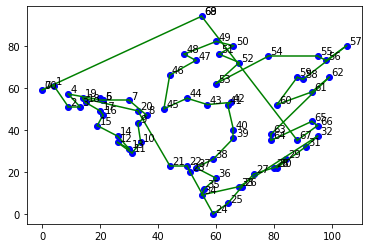

In [344]:
plot_tour(nn_sp.best_solution, matrix);